In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)

results_path = "results/fd001_predictions_physical_features.csv"
df = pd.read_csv(results_path)

df.head()

,UnitNumber,TimeInCycles,TrueRUL,PredRUL,Effizienz_HPC_Proxy,EGT_Drift,Fan_HPC_Ratio
0,1,31,112.0,125.000000,0.941146,1.3,0.406382
1,2,49,98.0,125.000000,0.942586,-1.4,0.404988
2,3,126,69.0,45.517113,0.942525,2.2,0.404391
3,4,106,82.0,73.614580,0.944340,2.7,0.403116
4,5,98,91.0,99.430110,0.941640,1.2,0.403959


In [13]:
y_true = df["TrueRUL"].values
y_pred = df["PredRUL"].values

errors = y_pred - y_true

mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(errors))
bias = np.mean(errors)

print(f"MSE : {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"Bias (pred - true): {bias:.3f}")


MSE : 238.312
RMSE: 15.437
MAE : 10.747
Bias (pred - true): 3.750


In [14]:
bins = [0, 25, 50, 100, 200, 400]
labels = ["0–25", "25–50", "50–100", "100–200", "200–400"]

df["RUL_bin"] = pd.cut(df["TrueRUL"], bins=bins, labels=labels, right=True)

grouped = df.groupby("RUL_bin").apply(
    lambda g: pd.Series({
        "n": len(g),
        "RMSE": np.sqrt(np.mean((g["PredRUL"] - g["TrueRUL"])**2)),
        "MAE": np.mean(np.abs(g["PredRUL"] - g["TrueRUL"])),
        "Bias": np.mean(g["PredRUL"] - g["TrueRUL"]),
    })
)

grouped


C:\Users\rober\AppData\Local\Temp\ipykernel_24448\3712030487.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("RUL_bin").apply(
C:\Users\rober\AppData\Local\Temp\ipykernel_24448\3712030487.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby("RUL_bin").apply(


,n,RMSE,MAE,Bias
RUL_bin,,,,
0–25,19.0,4.386038,3.233720,2.453250
25–50,14.0,5.584977,4.615396,-0.503772
50–100,34.0,22.115891,17.784816,8.124507
100–200,33.0,13.925309,10.424272,1.792837
200–400,0.0,NaN,NaN,NaN


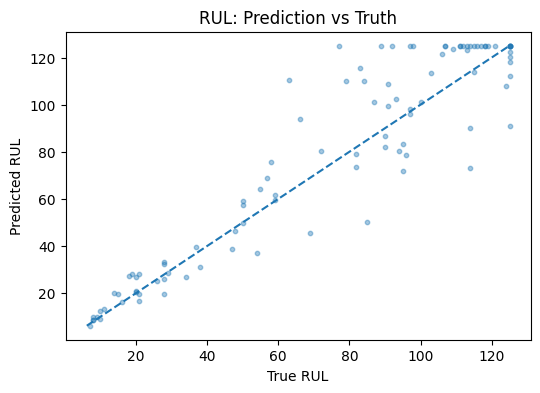

In [15]:
plt.scatter(y_true, y_pred, alpha=0.4, s=10)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("RUL: Prediction vs Truth")
plt.show()


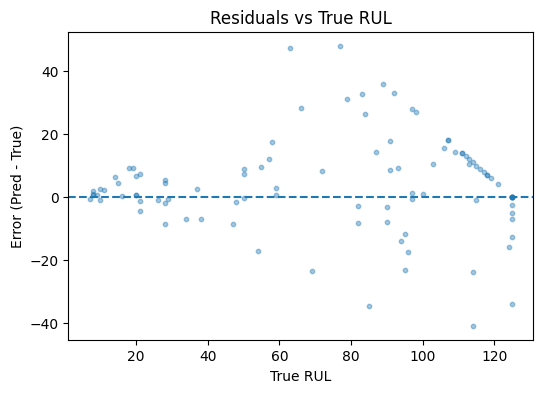

In [16]:
plt.scatter(y_true, errors, alpha=0.4, s=10)
plt.axhline(0, linestyle="--")
plt.xlabel("True RUL")
plt.ylabel("Error (Pred - True)")
plt.title("Residuals vs True RUL")
plt.show()


In [17]:
df["Error"] = df["PredRUL"] - df["TrueRUL"]

per_unit = df.groupby("UnitNumber").agg(
    n=("Error", "count"),
    RMSE=("Error", lambda e: np.sqrt(np.mean(e**2))),
    MAE=("Error", lambda e: np.mean(np.abs(e))),
    Bias=("Error", "mean"),
)

per_unit.sort_values("RMSE", ascending=False).head(10)


,n,RMSE,MAE,Bias
UnitNumber,,,,
67,1,48.000000,48.000000,48.000000
79,1,47.422424,47.422424,47.422424
45,1,40.816185,40.816185,-40.816185
86,1,36.000000,36.000000,36.000000
93,1,34.670998,34.670998,-34.670998
74,1,33.885710,33.885710,-33.885710
48,1,33.000000,33.000000,33.000000
15,1,32.707504,32.707504,32.707504
50,1,31.231210,31.231210,31.231210


In [18]:
worst_units = per_unit.sort_values("RMSE", ascending=False).head(3).index.tolist()
worst_units


[67, 79, 45]

In [19]:
corr_cols = ["TrueRUL", "PredRUL", "Effizienz_HPC_Proxy", "EGT_Drift", "Fan_HPC_Ratio"]
df[corr_cols].corr()


,TrueRUL,PredRUL,Effizienz_HPC_Proxy,EGT_Drift,Fan_HPC_Ratio
TrueRUL,1.000000,0.936463,-0.098350,-0.653669,0.605295
PredRUL,0.936463,1.000000,-0.141129,-0.698262,0.668025
Effizienz_HPC_Proxy,-0.098350,-0.141129,1.000000,0.103661,-0.162089
EGT_Drift,-0.653669,-0.698262,0.103661,1.000000,-0.464545
Fan_HPC_Ratio,0.605295,0.668025,-0.162089,-0.464545,1.000000


In [20]:
import numpy as np

def nasa_phm08_score(y_true, y_pred):
    """
    Compute the NASA PHM08 scoring function for RUL predictions.

    y_true: array-like of shape (n_samples,)
    y_pred: array-like of shape (n_samples,)

    Returns:
        float: total NASA score (lower is better, 0 is perfect)
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    d = y_pred - y_true  # positive: late (too optimistic), negative: early (too pessimistic)

    score = np.zeros_like(d, dtype=float)

    # Early predictions (d < 0) -> milder penalty
    mask_early = d < 0
    score[mask_early] = np.exp(-d[mask_early] / 13.0) - 1.0

    # Late predictions (d >= 0) -> stronger penalty
    mask_late = ~mask_early
    score[mask_late] = np.exp(d[mask_late] / 10.0) - 1.0

    return np.sum(score)


In [21]:
y_true = df["TrueRUL"].values
y_pred = df["PredRUL"].values

errors = y_pred - y_true

mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(errors))
bias = np.mean(errors)

nasa_score = nasa_phm08_score(y_true, y_pred)

print(f"Global MSE       : {mse:.3f}")
print(f"Global RMSE      : {rmse:.3f} cycles")
print(f"Global MAE       : {mae:.3f} cycles")
print(f"Global Bias      : {bias:.3f} (pred - true)")
print(f"NASA PHM08 Score : {nasa_score:.3f}")


Global MSE       : 238.312
Global RMSE      : 15.437 cycles
Global MAE       : 10.747 cycles
Global Bias      : 3.750 (pred - true)
NASA PHM08 Score : 559.721


In [22]:
bins = [0, 25, 50, 100, 200, 400]
labels = ["0–25", "25–50", "50–100", "100–200", "200–400"]
df["RUL_bin"] = pd.cut(df["TrueRUL"], bins=bins, labels=labels, right=True)

def nasa_score_per_group(group):
    return nasa_phm08_score(group["TrueRUL"].values, group["PredRUL"].values)

bin_scores = df.groupby("RUL_bin").apply(
    lambda g: pd.Series({
        "n": len(g),
        "RMSE": np.sqrt(np.mean((g["PredRUL"] - g["TrueRUL"])**2)),
        "MAE": np.mean(np.abs(g["PredRUL"] - g["TrueRUL"])),
        "NASA_score": nasa_score_per_group(g),
    })
)

bin_scores


C:\Users\rober\AppData\Local\Temp\ipykernel_24448\2498584759.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_scores = df.groupby("RUL_bin").apply(
C:\Users\rober\AppData\Local\Temp\ipykernel_24448\2498584759.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bin_scores = df.groupby("RUL_bin").apply(


,n,RMSE,MAE,NASA_score
RUL_bin,,,,
0–25,19.0,4.386038,3.233720,8.293539
25–50,14.0,5.584977,4.615396,7.766946
50–100,34.0,22.115891,17.784816,456.807540
100–200,33.0,13.925309,10.424272,86.852649
200–400,0.0,NaN,NaN,0.000000
